# Dataset Testing Notebook

This notebook is for testing each dataset individually:
1. RID Dataset (Segmentation)
2. Roofline Dataset (Line Detection)
3. AIRS Dataset (Building Outlines)

We'll use minimal configurations to verify data loading and processing.

In [1]:
# Add project root to path
import sys
import os
from pathlib import Path

# Get absolute path to project root
notebook_dir = Path(os.getcwd())
project_root = notebook_dir.parent
print(f"Project root: {project_root}")
sys.path.append(str(project_root))

# Import dependencies
import torch
import matplotlib.pyplot as plt
import numpy as np

# Import our modules
from src.data import RoofDataset, create_dataloaders
from src.models import create_model

# Set up plotting
%matplotlib inline

Project root: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model


## Configuration

In [2]:
# Training settings
config = {
    'batch_size': 2,
    'num_workers': 2,
    'max_samples': 10,
    'image_size': 512,
    'num_classes': 12
}

# Dataset paths - using absolute paths
rid_path = project_root / 'Reference Materials' / 'data' / 'RID' / 'm1655470' / 'RID_dataset'

print("\nChecking RID dataset path:")
print(f"RID dataset path: {rid_path}")

# Verify RID path exists
print("\nVerifying RID dataset structure:")
print(f"Path exists: {rid_path.exists()}")
if rid_path.exists():
    print(f"Contents:")
    for item in rid_path.iterdir():
        if item.is_dir():
            print(f"  - {item.name}/")
        else:
            print(f"  - {item.name}")

    # Verify required subdirectories
    required_dirs = [
        'filenames_train_val_test_split',
        'images_roof_centered_geotiff',
        'masks_segments_reviewed'
    ]
    
    missing_dirs = [d for d in required_dirs if not (rid_path / d).exists()]
    if missing_dirs:
        print("\nMissing required directories:")
        for d in missing_dirs:
            print(f"  - {d}")
        raise RuntimeError("Missing required RID dataset directories")
    
    # Set up data paths
    data_paths = {
        'rid': str(rid_path)
    }
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\nUsing device: {device}')
else:
    raise RuntimeError("RID dataset path does not exist")


Checking RID dataset path:
RID dataset path: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset

Verifying RID dataset structure:
Path exists: True
Contents:
  - filenames_train_val_test_split/
  - images_annotation_experiment_geotiff/
  - images_roof_centered_geotiff/
  - masks_segments_reviewed/
  - masks_superstructures_annotation_experiment/
  - masks_superstructures_reviewed/
  - README_data.md

Using device: cpu


## Visualization Functions

In [6]:
def show_batch(images, targets, dataset_type):
    """Display a batch of images and their targets."""
    batch_size = images.shape[0]
    fig, axes = plt.subplots(batch_size, 4, figsize=(20, 5*batch_size))
    
    for i in range(batch_size):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        axes[i,0].imshow(img)
        axes[i,0].set_title('Original Image')
        
        # Segmentation mask
        mask = targets['segments'][i].numpy()
        axes[i,1].imshow(mask, cmap='tab20')
        axes[i,1].set_title('Segmentation Mask')
        
        # Line detection
        lines = targets['lines'][i].numpy()
        line_vis = np.zeros((*lines.shape[1:], 3))
        line_vis[...,0] = lines[0]  # Ridge lines (red)
        line_vis[...,1] = lines[1]  # Valley lines (green)
        line_vis[...,2] = lines[3]  # Building outline (blue)
        axes[i,2].imshow(line_vis)
        axes[i,2].set_title('Line Detection')
        
        # Depth map
        depth = targets['depth'][i].numpy()
        axes[i,3].imshow(depth, cmap='viridis')
        axes[i,3].set_title('Depth Map')
    
    plt.tight_layout()
    return fig

def show_predictions(images, targets, predictions, dataset_type):
    """Display predictions alongside ground truth."""
    batch_size = images.shape[0]
    fig, axes = plt.subplots(batch_size, 4, figsize=(20, 5*batch_size))
    
    for i in range(batch_size):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        axes[i,0].imshow(img)
        axes[i,0].set_title('Original Image')
        
        # Segmentation prediction
        pred_mask = torch.argmax(predictions['segments'][i], dim=0).numpy()
        true_mask = targets['segments'][i].numpy()
        axes[i,1].imshow(pred_mask, cmap='tab20', alpha=0.7)
        axes[i,1].imshow(true_mask, cmap='tab20', alpha=0.3)
        axes[i,1].set_title('Segmentation (Pred/True)')
        
        # Line detection
        pred_lines = predictions['lines'][i].numpy()
        true_lines = targets['lines'][i].numpy()
        line_vis = np.zeros((*pred_lines.shape[1:], 3))
        line_vis[...,0] = pred_lines[0]  # Predicted (red)
        line_vis[...,1] = true_lines[0]  # True (green)
        axes[i,2].imshow(line_vis)
        axes[i,2].set_title('Lines (Pred/True)')
        
        # Depth prediction
        pred_depth = predictions['depth'][i].squeeze().numpy()  # Added squeeze()
        true_depth = targets['depth'][i].numpy()
        depth_diff = np.abs(pred_depth - true_depth)
        axes[i,3].imshow(depth_diff, cmap='viridis')
        axes[i,3].set_title('Depth Error')
    
    plt.tight_layout()
    return fig

## Test RID Dataset

INFO:root:Creating dataloaders for rid dataset
INFO:root:Dataset path: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset
INFO:root:Using max_samples=10 for testing
INFO:root:Loading RID dataset from:
INFO:root:- Base directory: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset
INFO:root:- Split directory: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset\filenames_train_val_test_split
INFO:root:- Image directory: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset\images_roof_centered_geotiff
INFO:root:- Mask directory: C:\Users\quick\Documents\Projects\EZ Ridge - V7 - Outline Model\Reference Materials\data\RID\m1655470\RID_dataset\masks_segments_reviewed
INFO:root:Available directories:
INFO:root:- filenames_train_val_test_split/
INFO:

Creating dataloaders...


INFO:root:Found image/mask pair: 547.tif
INFO:root:Found image/mask pair: 87.tif
INFO:root:Found image/mask pair: 817.tif
INFO:root:Found image/mask pair: 1419.tif
INFO:root:Found image/mask pair: 466.tif
INFO:root:Found image/mask pair: 918.tif
INFO:root:Found image/mask pair: 1398.tif
INFO:root:Found image/mask pair: 1624.tif
INFO:root:Found image/mask pair: 1220.tif
INFO:root:Found image/mask pair: 1148.tif
INFO:root:Found image/mask pair: 1924.tif
INFO:root:Found image/mask pair: 144.tif
INFO:root:Found image/mask pair: 1916.tif
INFO:root:Found image/mask pair: 255.tif
INFO:root:Found image/mask pair: 1667.tif
INFO:root:Found image/mask pair: 114.tif
INFO:root:Found image/mask pair: 73.tif
INFO:root:Found image/mask pair: 143.tif
INFO:root:Found image/mask pair: 1734.tif
INFO:root:Found image/mask pair: 325.tif
INFO:root:Found image/mask pair: 1092.tif
INFO:root:Found image/mask pair: 1096.tif
INFO:root:Found image/mask pair: 427.tif
INFO:root:Found image/mask pair: 70.tif
INFO:roo

Loaded 10 images from rid dataset (train split)


INFO:root:Found image/mask pair: 1912.tif
INFO:root:Found image/mask pair: 323.tif
INFO:root:Found image/mask pair: 900.tif
INFO:root:Found image/mask pair: 838.tif
INFO:root:Found image/mask pair: 164.tif
INFO:root:Found image/mask pair: 652.tif
INFO:root:Found image/mask pair: 2019.tif
INFO:root:Found image/mask pair: 547.tif
INFO:root:Found image/mask pair: 1166.tif
INFO:root:Found image/mask pair: 817.tif
INFO:root:Found image/mask pair: 1419.tif
INFO:root:Found image/mask pair: 918.tif
INFO:root:Found image/mask pair: 1398.tif
INFO:root:Found image/mask pair: 1624.tif
INFO:root:Found image/mask pair: 1220.tif
INFO:root:Found image/mask pair: 1924.tif
INFO:root:Found image/mask pair: 144.tif
INFO:root:Found image/mask pair: 1916.tif
INFO:root:Found image/mask pair: 255.tif
INFO:root:Found image/mask pair: 1667.tif
INFO:root:Found image/mask pair: 114.tif
INFO:root:Found image/mask pair: 73.tif
INFO:root:Found image/mask pair: 1734.tif
INFO:root:Found image/mask pair: 325.tif
INFO:r


Batch information:
Images shape: torch.Size([2, 3, 512, 512])
Number of images: 2
Target keys: ['segments', 'lines', 'depth', 'dataset_type']

Displaying batch...


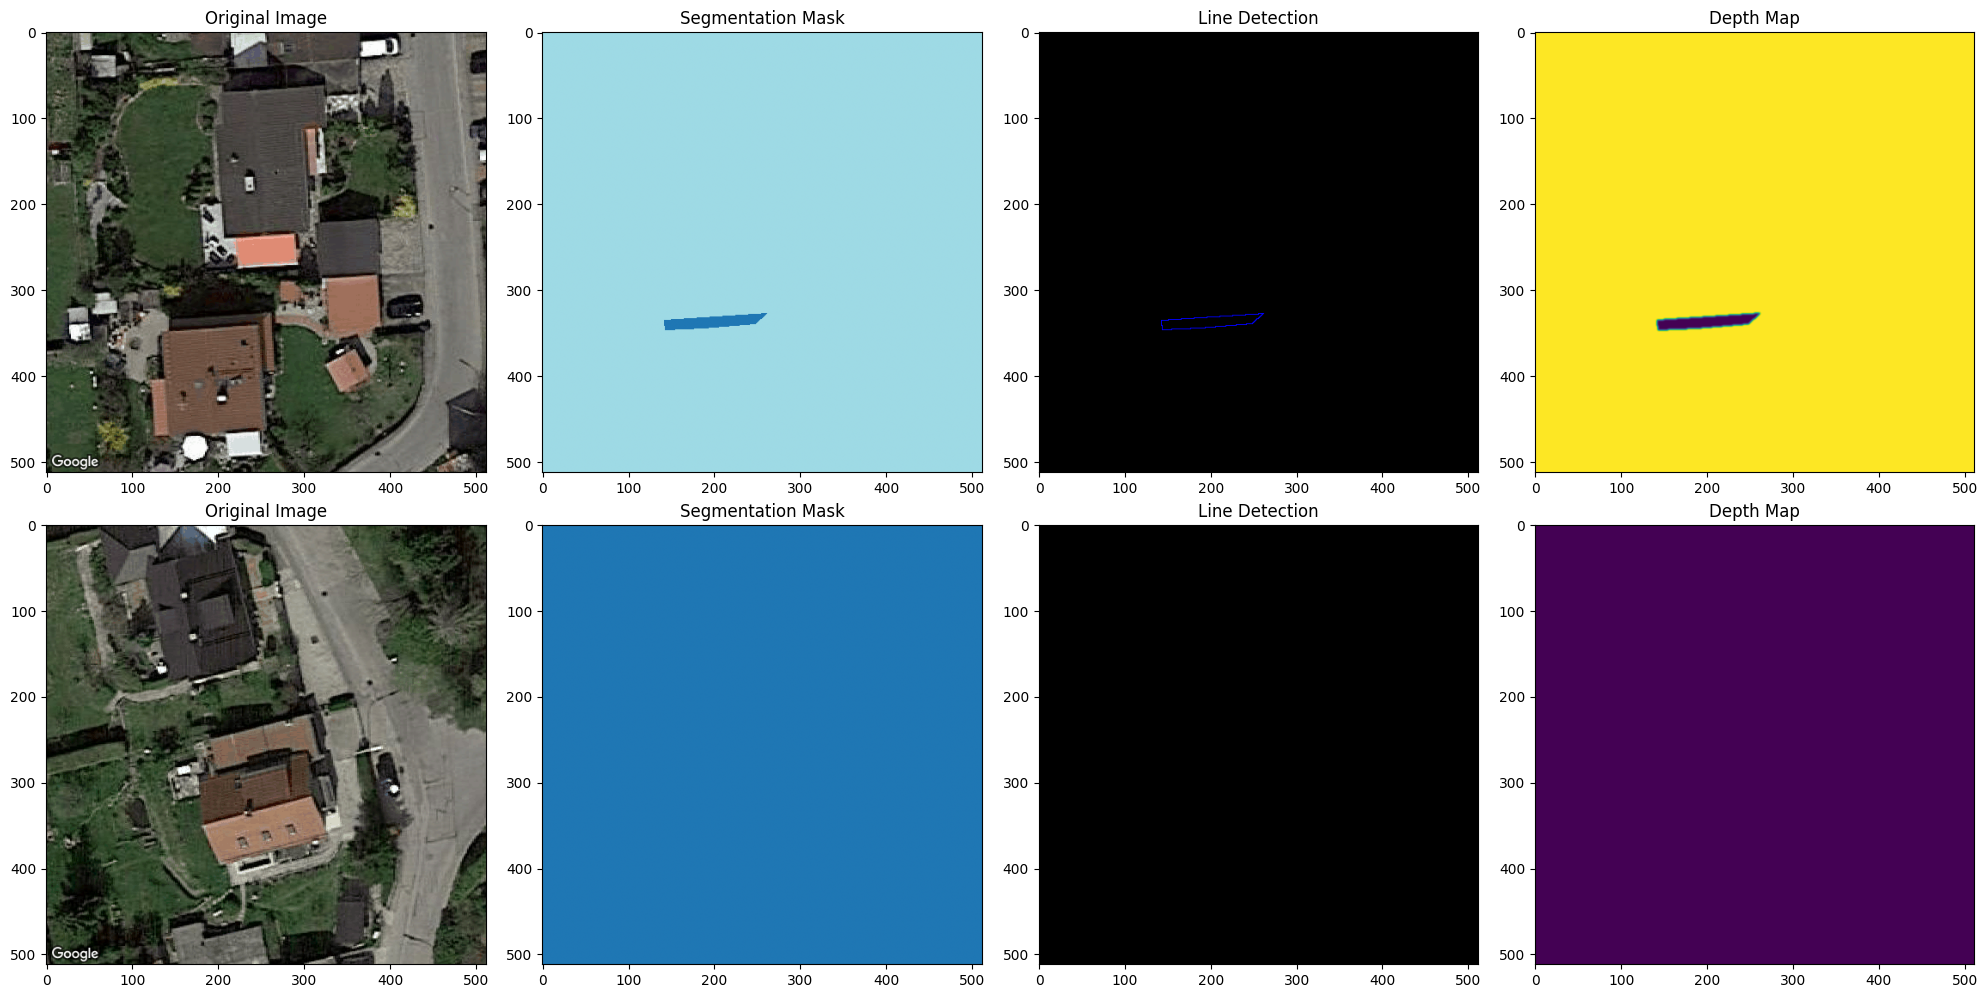

In [4]:
# Enable more detailed logging
import logging
logging.basicConfig(level=logging.INFO)

# Create RID dataset and dataloader
print("Creating dataloaders...")
rid_train_loader, rid_val_loader = create_dataloaders(
    data_paths['rid'],
    'rid',
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    max_samples=config['max_samples']
)

print("\nGetting a batch of data...")
images, targets = next(iter(rid_train_loader))

print("\nBatch information:")
print(f"Images shape: {images.shape}")
print(f"Number of images: {len(images)}")
print(f"Target keys: {list(targets.keys())}")

# Display the batch
print("\nDisplaying batch...")
show_batch(images, targets, 'rid')

## Test Model with RID Data

Total loss: 4.1817
segments loss: 2.8133
lines loss: 0.9655
depth loss: 0.4028


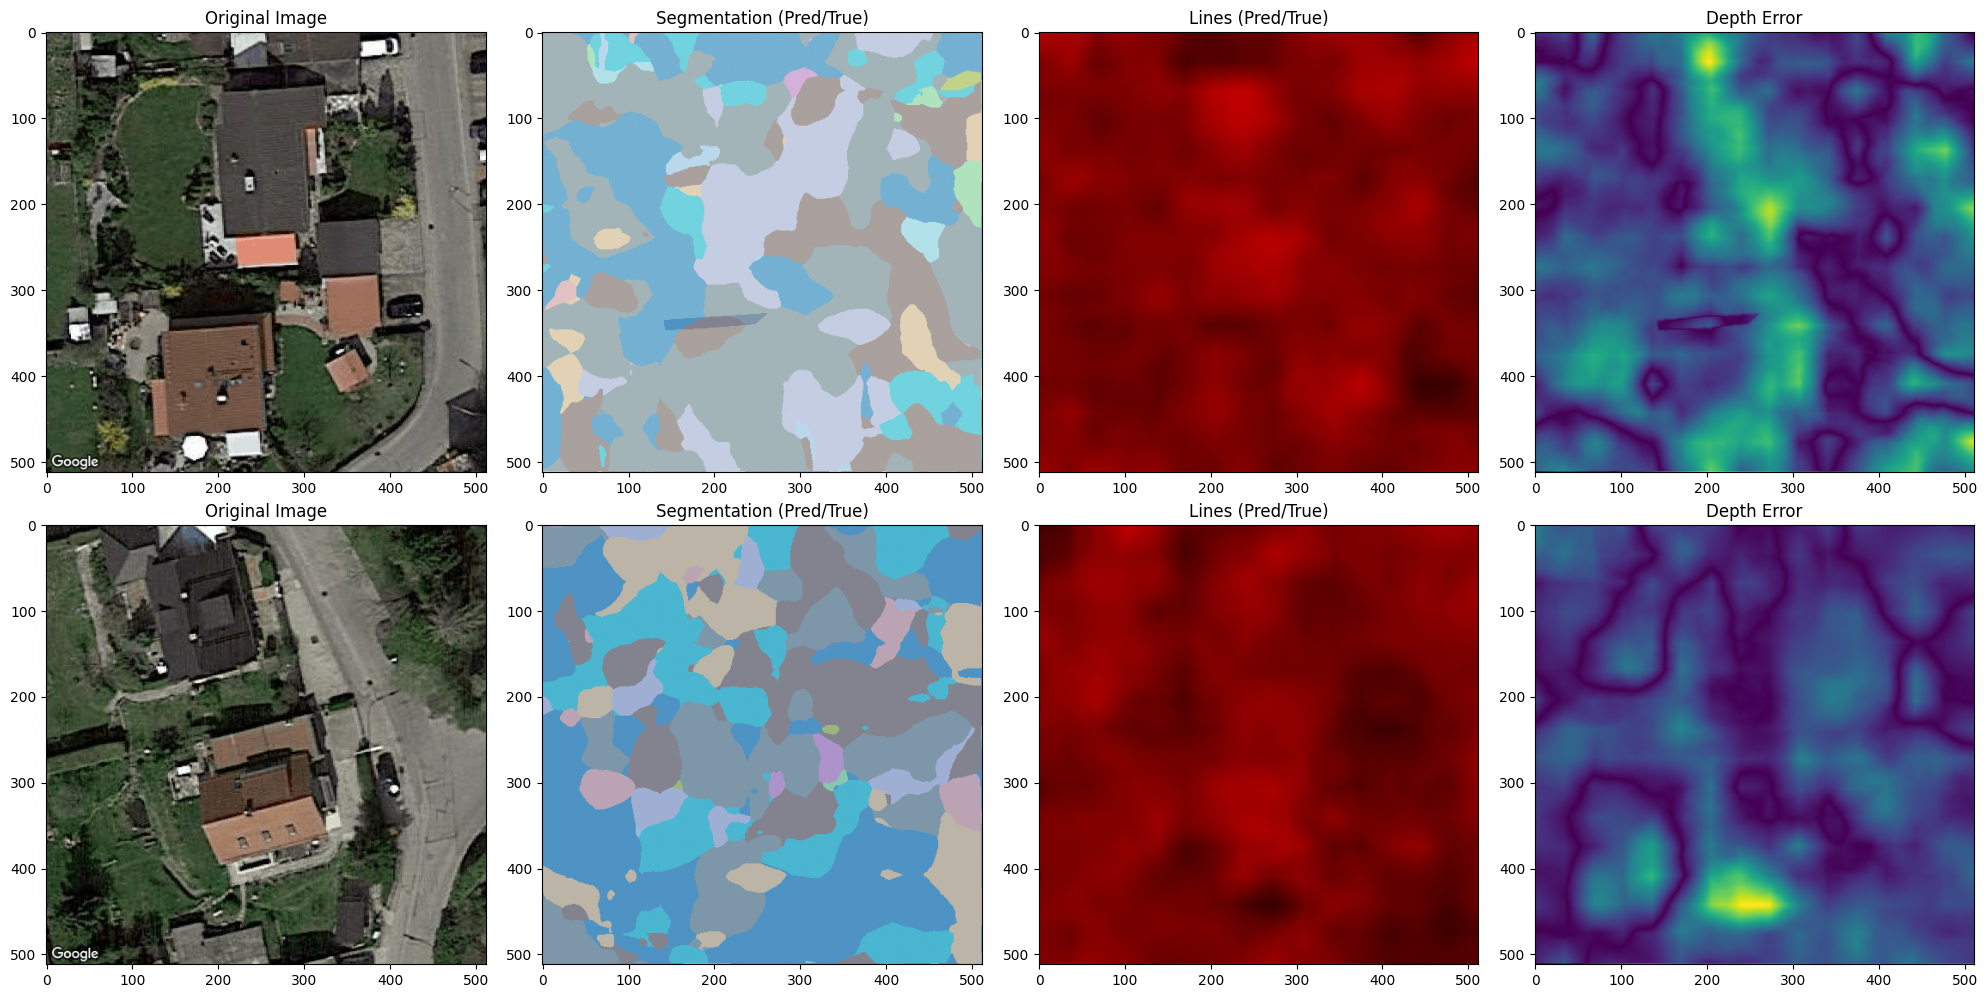

In [7]:
# Create model
model, criterion = create_model(num_classes=config['num_classes'])
model = model.to(device)
model.train()

# Move batch to device
images = images.to(device)
device_targets = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                 for k, v in targets.items()}

# Get predictions
with torch.no_grad():
    predictions = model(images)

# Calculate loss
loss, losses_dict = criterion(predictions, device_targets)
print(f'Total loss: {loss.item():.4f}')
for k, v in losses_dict.items():
    print(f'{k} loss: {v.item():.4f}')

# Move everything back to CPU for visualization
images = images.cpu()
predictions = {k: v.cpu() for k, v in predictions.items()}
targets = {k: v.cpu() if isinstance(v, torch.Tensor) else v
          for k, v in targets.items()}

# Show predictions
show_predictions(images, targets, predictions, 'rid')

## Next Steps

After verifying RID dataset works:
1. Test Roofline dataset
2. Test AIRS dataset
3. Test dataset transitions
4. Document results